In [95]:
import os
import gc
import subprocess
import warnings
import numpy as np
import pandas as pd
import torch
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import lightgbm as lgb

warnings.filterwarnings('ignore')

In [96]:
def create_mlp_model(input_shape):
    model = Sequential([
        layers.Dense(1024, activation="relu", input_shape=(input_shape,)),
        layers.Dropout(0.3),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="linear")  # regression output
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

def create_cnn_model(input_shape):
    # input_shape should be (n_features, 1)
    model = Sequential([
        layers.Conv1D(128, kernel_size=3, activation='relu', input_shape=(input_shape[0], 1)),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='linear')  # regression output
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

In [97]:
def clean_up_cuda(model):
    K.clear_session()
    del model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    print("CUDA memory cleared and model deleted.")


In [98]:
def feature_extraction_best_corr_with_target(X, X_val, X_control, y, threshold=0.6, df_columns=None, number_of_features=40):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
        if df_columns is not None:
            X.columns = df_columns
    if isinstance(y, np.ndarray):
        y = pd.Series(y)
    if isinstance(X_val, np.ndarray):
        X_val = pd.DataFrame(X_val)
        if df_columns is not None:
            X_val.columns = df_columns
    if isinstance(X_control, np.ndarray):
        X_control = pd.DataFrame(X_control)
        if df_columns is not None:
            X_control.columns = df_columns
    correlation_matrix = X.corrwith(y).abs()
    to_keep = correlation_matrix.sort_values(ascending=False).head(number_of_features).index
    X = X[to_keep]
    X_val = X_val[to_keep]
    X_control = X_control[to_keep]
    return X.to_numpy().copy(), X_val.to_numpy().copy(), X_control.to_numpy().copy()

def feature_extraction_with_Pearson(X, X_val, X_control, y, threshold=0.6, df_columns=None):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
        if df_columns is not None:
            X.columns = df_columns
    if isinstance(X_val, np.ndarray):
        X_val = pd.DataFrame(X_val)
        if df_columns is not None:
            X_val.columns = df_columns
    if isinstance(X_control, np.ndarray):
        X_control = pd.DataFrame(X_control)
        if df_columns is not None:
            X_control.columns = df_columns
    correlation_matrix = X.corr().abs()
    upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    X = X.drop(columns=to_drop)
    X_val = X_val.drop(columns=to_drop)
    X_control = X_control.drop(columns=to_drop)
    return X.to_numpy().copy(), X_val.to_numpy().copy(), X_control.to_numpy().copy()

def feature_extration_with_PCA(X, X_val, X_control, n_components):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(X), pca.transform(X_val), pca.transform(X_control)

def feature_extration_with_BE(X, X_val, X_control, y, significance_level=0.05, df_columns=None):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
        if df_columns is not None:
            X.columns = df_columns
    if isinstance(X_val, np.ndarray):
        X_val = pd.DataFrame(X_val)
        if df_columns is not None:
            X_val.columns = df_columns
    if isinstance(X_control, np.ndarray):
        X_control = pd.DataFrame(X_control)
        if df_columns is not None:
            X_control.columns = df_columns
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    X = sm.add_constant(X)
    while True:
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            feature_to_remove = p_values.idxmax()
            print(f"Removing {feature_to_remove} with p-value {max_p_value:.4f}")
            X = X.drop(columns=[feature_to_remove])
            X_val = X_val.drop(columns=[feature_to_remove])
            X_control = X_control.drop(columns=[feature_to_remove])
        else:
            break
        print("Final Feature length: ", len(X.columns))
    X_ret = X.drop(columns=['const']).to_numpy().copy()
    return X_ret, X_val.to_numpy().copy(), X_control.to_numpy().copy()


In [99]:
def pearson_correlation_coefficient(y_true, y_pred):
    if len(y_true) <= 1 or len(y_pred) <= 1:
        raise ValueError("Pearson correlation requires at least two points in each array.")
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length.")

    # Convert input to pandas series (if not already)
    y_true = pd.Series(y_true).astype(int)
    y_pred = pd.Series(y_pred).astype(int)

    # Check for NaNs or infinite values
    if y_true.isna().any() or y_pred.isna().any():
        raise ValueError("Input contains NaN values.")
    if not np.isfinite(y_true).all() or not np.isfinite(y_pred).all():
        raise ValueError("Input contains infinite values.")

    # Compute and return the correlation
    result = y_true.corr(y_pred)
    if np.isnan(result):
        return 0.0
    return result

def evaluate_regression_performance(y_true, y_pred, title=""):
    y_pred = np.round(y_pred).astype(int)
    #round y_true and make it an array
    y_true = np.round(np.array(y_true)).astype(int)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    pearson = pearson_correlation_coefficient(y_true, y_pred)
    results = {
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'pearson': pearson
    }
    print(f"\n {title} Regressor Performance:")
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}, Pearson: {pearson:.4f}")
    return results

def aggregate_cv_metrics_and_print(all_results, model_name, tag="Validation"):
    aggregated = {'mse': [], 'mae': [], 'r2': [], 'pearson': []}
    for result in all_results:
        aggregated['mse'].append(result['mse'])
        aggregated['mae'].append(result['mae'])
        aggregated['r2'].append(result['r2'])
        aggregated['pearson'].append(result['pearson'])
    summary = {
        'mean_mse': np.mean(aggregated['mse']),
        'std_mse': np.std(aggregated['mse']),
        'mean_mae': np.mean(aggregated['mae']),
        'std_mae': np.std(aggregated['mae']),
        'mean_r2': np.mean(aggregated['r2']),
        'std_r2': np.std(aggregated['r2']),
        'mean_pearson': np.mean(aggregated['pearson']),
    }
    print(f"\n {model_name} Regressor Performance {tag}:")
    for k, v in summary.items():
        print(f"{k}: {v}")
    return summary

label_age_group
7.0    1482
8.0    1471
6.0    1360
5.0    1257
4.0    1083
9.0    1052
3.0     959
2.0     812
1.0     356
0.0     168
Name: count, dtype: int64
Total samples: 10000


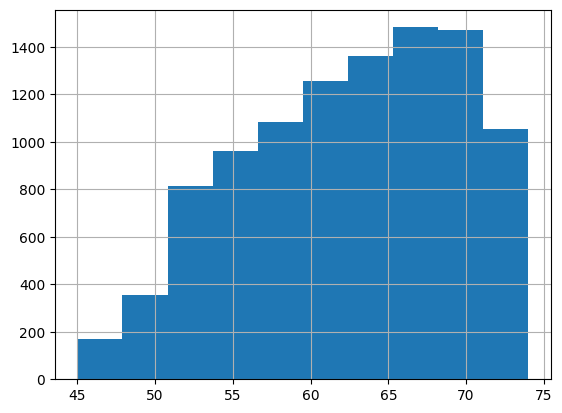

In [100]:
label_col= "label_Age"
straticify_col = "label_age_group"

os.makedirs("/opt/notebooks/TABPFN/02_UKB/00_data/age_label", exist_ok=True)
os.makedirs("/opt/notebooks/TABPFN/02_UKB/00_data/deconfounded_but_age", exist_ok=True)
mri_table = "aseg.volume_aparc.volume_aparc.thickness.csv"
""" # Load the age data
command = "dx download file-GyGfBQ8J34gPK8XXxbjYGbg4 --output /opt/notebooks/TABPFN/02_UKB/00_data/age_label/all_ages_all_ids_healthy.csv --overwrite"
subprocess.run(command, shell=True, check=True)
#load mri data
command = f"dx download file-GyGf9vjJ34g2g9QbJQ7P1qZG --output '/opt/notebooks/TABPFN/02_UKB/00_data/deconfounded_but_age/{mri_table}' --overwrite"
subprocess.run(command, shell=True, check=True) """

# Load the age data middle
command = "dx download file-GyJp51jJ34g246Y7bZ6j7yK4 --output /opt/notebooks/TABPFN/02_UKB/00_data/age_label/all_ages_all_ids_healthy.csv --overwrite"
subprocess.run(command, shell=True, check=True)
#load mri data cleand and renamed but age
command = f"dx download file-GyJp6B0J34g8xpf6Q6jz12xJ --output '/opt/notebooks/TABPFN/02_UKB/00_data/deconfounded_but_age/{mri_table}' --overwrite"
subprocess.run(command, shell=True, check=True)
df = pd.read_csv(f"../00_data/deconfounded_but_age/{mri_table}")
label_df = pd.read_csv("../00_data/age_label/all_ages_all_ids_healthy.csv")
n_splits = 5
label_df = label_df[['ID', label_col, straticify_col]]
merged_df = pd.merge(df, label_df, on='ID', how='inner')
merged_df.dropna(inplace=True)

label_counts = merged_df[straticify_col].value_counts()

# Include all rows for groups with fewer samples than the target threshold
threshold = 1000  # You can adjust this threshold as needed
small_groups = label_counts[label_counts <= threshold].index
small_groups_df = merged_df[merged_df[straticify_col].isin(small_groups)]

# Calculate how many more samples are needed to reach 10,000
remaining_needed = 10000 - len(small_groups_df)

# Sample proportionally from the larger groups
large_groups = label_counts[label_counts > threshold].index
large_groups_df = merged_df[merged_df[straticify_col].isin(large_groups)]

# Stratified sampling from the remaining data
proportional_sampled_df, _ = train_test_split(
    large_groups_df, 
    train_size=remaining_needed, 
    stratify=large_groups_df[straticify_col], 
    random_state=42
)

# Combine the small groups and the proportional sample
final_sampled_df = pd.concat([small_groups_df, proportional_sampled_df])

# Verify the result
print(final_sampled_df[straticify_col].value_counts())
print(f"Total samples: {len(final_sampled_df)}")
if label_col != straticify_col:
    final_sampled_df.drop(columns=[straticify_col], inplace=True)
final_sampled_df[label_col].hist()
df_sampled = final_sampled_df

Only 250 samples available after balanced sampling.


<Axes: >

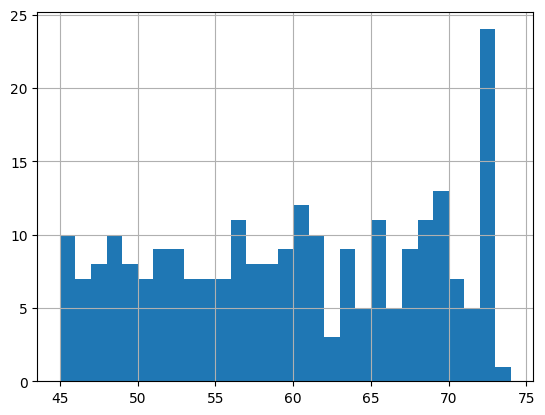

In [101]:
os.makedirs("/opt/notebooks/TABPFN/02_UKB/00_data/validation_data/00_National_Cohort/", exist_ok=True)
#load middle age control data
command = "dx download file-GyK09JQJ34g95zyvV9vFxQFv --output /opt/notebooks/TABPFN/02_UKB/00_data/validation_data/00_National_Cohort/all_ages_all_ids_subset_middle_age.csv --overwrite"
subprocess.run(command, shell=True)
#load mri data
command = "dx download file-GyK08xjJ34g95zyvV9vFxQFf --output /opt/notebooks/TABPFN/02_UKB/00_data/validation_data/00_National_Cohort/aparc.thickness_aseg.volume_aparc.volume_deconfounded_but_age.csv --overwrite"
subprocess.run(command, shell=True)

label_df_control = pd.read_csv("../00_data/validation_data/00_National_Cohort/all_ages_all_ids_subset_middle_age.csv")
df_control = pd.read_csv("../00_data/validation_data/00_National_Cohort/aparc.thickness_aseg.volume_aparc.volume_deconfounded_but_age.csv")

label_df_control = label_df_control[['ID', straticify_col, label_col]]
merged_df_control = pd.merge(df_control, label_df_control, on='ID', how='inner')
merged_df_control.dropna(inplace=True)
#sample 400 so that from each group 25 samples if possible
target_samples_per_group = 25
grouped_df = merged_df_control.groupby(straticify_col)

# Sample 25 from each group if possible, otherwise sample all available
sampled_control = grouped_df.apply(lambda x: x.sample(n=min(target_samples_per_group, len(x)), random_state=42))

# Reset the index after sampling
sampled_control.reset_index(drop=True, inplace=True)

# Check if we reached the desired total number of 400 samples
if len(sampled_control) < 400:
    print(f"Only {len(sampled_control)} samples available after balanced sampling.")
else:
    print(f"Sampled {len(sampled_control)} rows with balanced distribution across groups.")

X_control_source = sampled_control.drop(["ID", label_col], axis=1)
y_control_source = sampled_control[label_col]
control_ids = sampled_control["ID"]
y_control_source.hist(bins=29)

In [102]:
column_control = df_sampled.drop([label_col, "ID"], axis=1).columns
X_control = X_control_source[column_control]
y_control_max = y_control_source.max()
y_control_min = y_control_source.min()

In [103]:
len(X_control.columns)

192

In [ ]:
n_splits = 5
# You can adjust these percentages as needed
percentage_of_the_data = [0.1]
deconfounding_strategies = ["Nothing"]

# Dictionary to store aggregated CV metrics for each percentage and deconfounding strategy
percentage_dict = {}

# Lists to record individual predictions (for test and control sets)
test_predictions_records = []    # will include real outcomes and predictions (test set from CV)
control_predictions_records = [] # will include real outcomes and predictions (control set)

# We will also record random-baseline metrics (using random predictions drawn from uniform [0,1])
random_results = []            # for test set performance
random_results_eval = []       # for control set evaluation (if desired)

# For each deconfounding strategy and percentage, we will also collect model metrics
# We will collect separate lists for test-set ("cv_results") and control-set ("cv_results_eval")
for percentage in percentage_of_the_data:
    percentage_dict[percentage] = {}
    
    # Subsample the training data as needed
    if percentage == 1:
        df_sampled_subset = df_sampled.copy()
    else:
        df_sampled_subset, _ = train_test_split(
            df_sampled,
            train_size=percentage,
            random_state=42
        )
    print(f"\n #### TRAINING WITH {percentage} OF THE DATA ####")
    # Separate IDs, outcomes, and features
    ids = df_sampled_subset["ID"]
    y = df_sampled_subset[label_col]
    X = df_sampled_subset.drop(["ID", label_col], axis=1)
    
    print(f"Training data shape: {X.shape}, number of samples: {len(y)}")
    
    for deconfounding_strategy in deconfounding_strategies:
        print(f"\n=== Deconfounding Strategy: {deconfounding_strategy} ===")
        
        # Prepare lists for storing CV metrics (for test set and for control set)
        mlp_results = []
        cnn_results = []
        lgb_results = []
        random_results_model = []  # for test-set random baseline
        
        mlp_results_eval = []
        cnn_results_eval = []
        lgb_results_eval = []
        random_results_eval_model = []  # for control-set random baseline (if desired)
        
        # Create a KFold object (using KFold for regression)
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_counter = 0
        for train_index, val_index in kf.split(X):
            fold_counter += 1
            print(f"\nFold {fold_counter}")
            X_train, X_test = X.iloc[train_index].copy(), X.iloc[val_index].copy()
            y_train, y_test = y.iloc[train_index].copy(), y.iloc[val_index].copy()
            test_ids = ids.iloc[val_index].copy()
            
            # Use the entire control set (IDs are stored in control_ids)
            X_control = X_control_source.copy()
            y_control = y_control_source.copy()
            try:
                X_control = X_control[X_train.columns]
            except Exception as e:
                print("Columns mismatch between training and control:", e)
            
            # Scale the data
            df_columns = X_train.columns
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            X_control_scaled = scaler.transform(X_control)
            
            # Apply deconfounding / feature extraction strategy
            if deconfounding_strategy == "BE":
                X_train_proc, X_test_proc, X_control_proc = feature_extration_with_BE(
                    X_train_scaled, X_test_scaled, X_control_scaled, y_train, df_columns=df_columns)
            elif deconfounding_strategy == "PCA":
                X_train_proc, X_test_proc, X_control_proc = feature_extration_with_PCA(
                    X_train_scaled, X_test_scaled, X_control_scaled, n_components=50)
            elif deconfounding_strategy == "Correlation_in_Feature":
                X_train_proc, X_test_proc, X_control_proc = feature_extraction_with_Pearson(
                    X_train_scaled, X_test_scaled, X_control_scaled, y_train, threshold=0.6, df_columns=df_columns)
            elif deconfounding_strategy == "Correlation_with_target":
                X_train_proc, X_test_proc, X_control_proc = feature_extraction_best_corr_with_target(
                    X_train_scaled, X_test_scaled, X_control_scaled, y_train, threshold=0.6, df_columns=df_columns)
            elif deconfounding_strategy == "Nothing":
                X_train_proc, X_test_proc, X_control_proc = X_train_scaled, X_test_scaled, X_control_scaled
            
            #############################
            # RANDOM BASELINE
            #############################
            n_samples_test = len(y_test)
            # Random predcition between min and max
            random_pred = np.random.uniform(y_test.min(), y_test.max(), n_samples_test)
            random_pred = np.round(random_pred)
            random_metrics = evaluate_regression_performance(y_test, random_pred, title="Random - Test")
            random_results_model.append(random_metrics)
            
            # For control set, random predictions as well:
            n_samples_control = len(y_control)
            random_control_pred = np.random.uniform(y_test.min(), y_test.max(), n_samples_control)
            random_metrics_eval = evaluate_regression_performance(y_control, random_control_pred, title="Random - Control")
            random_results_eval_model.append(random_metrics_eval)
            
            # Record random predictions in the prediction logs (for test set)
            for idx, true_val, pred_val in zip(test_ids, y_test, random_pred):
                test_predictions_records.append({
                    'ID': idx,
                    'fold': fold_counter,
                    'model': 'Random',
                    'real_outcome': true_val,
                    'predicted_outcome': pred_val,
                    'percentage': percentage,
                    'deconfounding': deconfounding_strategy
                })
            # And for control set
            for idx, true_val, pred_val in zip(control_ids, y_control, random_control_pred):
                control_predictions_records.append({
                    'ID': idx,
                    'fold': fold_counter,
                    'model': 'Random',
                    'real_outcome': true_val,
                    'predicted_outcome': pred_val,
                    'percentage': percentage,
                    'deconfounding': deconfounding_strategy
                })
            
            #############################
            # CNN Regressor
            #############################
            # Reshape for CNN: (samples, n_features, 1)
            X_train_cnn = X_train_proc.reshape(X_train_proc.shape[0], X_train_proc.shape[1], 1)
            X_test_cnn  = X_test_proc.reshape(X_test_proc.shape[0], X_test_proc.shape[1], 1)
            X_control_cnn = X_control_proc.reshape(X_control_proc.shape[0], X_control_proc.shape[1], 1)
            
            cnn_model = create_cnn_model(input_shape=(X_train_proc.shape[1], 1))
            cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, verbose=0)
            cnn_pred = cnn_model.predict(X_test_cnn).flatten()
            cnn_metrics = evaluate_regression_performance(y_test, cnn_pred, title="CNN - Test")
            cnn_results.append(cnn_metrics)
            
            # Record CNN predictions (test set)
            for idx, true_val, pred_val in zip(test_ids, y_test, cnn_pred):
                test_predictions_records.append({
                    'ID': idx,
                    'fold': fold_counter,
                    'model': 'CNN',
                    'real_outcome': true_val,
                    'predicted_outcome': pred_val,
                    'percentage': percentage,
                    'deconfounding': deconfounding_strategy
                })
            # Evaluate on control set
            cnn_control_pred = cnn_model.predict(X_control_cnn).flatten()
            cnn_control_metrics = evaluate_regression_performance(y_control, cnn_control_pred, title="CNN - Control")
            cnn_results_eval.append(cnn_control_metrics)
            # Record control predictions for CNN
            for idx, true_val, pred_val in zip(control_ids, y_control, cnn_control_pred):
                control_predictions_records.append({
                    'ID': idx,
                    'fold': fold_counter,
                    'model': 'CNN',
                    'real_outcome': true_val,
                    'predicted_outcome': pred_val,
                    'percentage': percentage,
                    'deconfounding': deconfounding_strategy
                })
            clean_up_cuda(cnn_model)
            
            #############################
            # MLP Regressor
            #############################
            mlp_model = create_mlp_model(input_shape=X_train_proc.shape[1])
            mlp_model.fit(X_train_proc, y_train, epochs=10, batch_size=32, verbose=0)
            mlp_pred = mlp_model.predict(X_test_proc).flatten()
            mlp_metrics = evaluate_regression_performance(y_test, mlp_pred, title="MLP - Test")
            mlp_results.append(mlp_metrics)
            # Record predictions for MLP (test set)
            for idx, true_val, pred_val in zip(test_ids, y_test, mlp_pred):
                test_predictions_records.append({
                    'ID': idx,
                    'fold': fold_counter,
                    'model': 'MLP',
                    'real_outcome': true_val,
                    'predicted_outcome': pred_val,
                    'percentage': percentage,
                    'deconfounding': deconfounding_strategy
                })
            # Evaluate on control set
            mlp_control_pred = mlp_model.predict(X_control_proc).flatten()
            mlp_control_metrics = evaluate_regression_performance(y_control, mlp_control_pred, title="MLP - Control")
            mlp_results_eval.append(mlp_control_metrics)
            # Record control predictions for MLP
            for idx, true_val, pred_val in zip(control_ids, y_control, mlp_control_pred):
                control_predictions_records.append({
                    'ID': idx,
                    'fold': fold_counter,
                    'model': 'MLP',
                    'real_outcome': true_val,
                    'predicted_outcome': pred_val,
                    'percentage': percentage,
                    'deconfounding': deconfounding_strategy
                })
            clean_up_cuda(mlp_model)
            
            #############################
            # LightGBM Regressor
            #############################
            lgb_train = lgb.Dataset(X_train_proc, label=y_train)
            params = {
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.05,
                'seed': 42,
                'verbose': -1
            }
            lgb_model = lgb.train(params, lgb_train, num_boost_round=100)
            lgb_pred = lgb_model.predict(X_test_proc)
            lgb_metrics = evaluate_regression_performance(y_test, lgb_pred, title="LGBM - Test")
            lgb_results.append(lgb_metrics)
            # Record predictions for LGBM (test set)
            for idx, true_val, pred_val in zip(test_ids, y_test, lgb_pred):
                test_predictions_records.append({
                    'ID': idx,
                    'fold': fold_counter,
                    'model': 'LGBM',
                    'real_outcome': true_val,
                    'predicted_outcome': pred_val,
                    'percentage': percentage,
                    'deconfounding': deconfounding_strategy
                })
            # Evaluate on control set
            lgb_control_pred = lgb_model.predict(X_control_proc)
            lgb_control_metrics = evaluate_regression_performance(y_control, lgb_control_pred, title="LGBM - Control")
            lgb_results_eval.append(lgb_control_metrics)
            # Record control predictions for LGBM
            for idx, true_val, pred_val in zip(control_ids, y_control, lgb_control_pred):
                control_predictions_records.append({
                    'ID': idx,
                    'fold': fold_counter,
                    'model': 'LGBM',
                    'real_outcome': true_val,
                    'predicted_outcome': pred_val,
                    'percentage': percentage,
                    'deconfounding': deconfounding_strategy
                })
            # LightGBM does not require GPU clean-up
            
        # End of CV folds for this deconfounding strategy
        
        # Aggregate and print performance for each model (test set)
        random_summary = aggregate_cv_metrics_and_print(random_results_model, "Random")
        cnn_summary = aggregate_cv_metrics_and_print(cnn_results, "CNN")
        mlp_summary = aggregate_cv_metrics_and_print(mlp_results, "MLP")
        lgb_summary = aggregate_cv_metrics_and_print(lgb_results, "LGBM")
        
        # Aggregate for control set evaluations
        random_eval_summary = aggregate_cv_metrics_and_print(random_results_eval_model, "Random", tag="Control")
        cnn_eval_summary = aggregate_cv_metrics_and_print(cnn_results_eval, "CNN", tag="Control")
        mlp_eval_summary = aggregate_cv_metrics_and_print(mlp_results_eval, "MLP", tag="Control")
        lgb_eval_summary = aggregate_cv_metrics_and_print(lgb_results_eval, "LGBM", tag="Control")
        
        # Save results in the dictionary
        percentage_dict[percentage][deconfounding_strategy] = {
            "Random": {
                "results": random_summary,
                "results_eval": random_eval_summary,
                "cv_results": random_results_model,
                "cv_results_eval": random_results_eval_model
            },
            "MLP": {
                "results": mlp_summary,
                "results_eval": mlp_eval_summary,
                "cv_results": mlp_results,
                "cv_results_eval": mlp_results_eval
            },
            "CNN": {
                "results": cnn_summary,
                "results_eval": cnn_eval_summary,
                "cv_results": cnn_results,
                "cv_results_eval": cnn_results_eval
            },
            "LGBM": {
                "results": lgb_summary,
                "results_eval": lgb_eval_summary,
                "cv_results": lgb_results,
                "cv_results_eval": lgb_results_eval
            }
        }

    # Set these flags as desired
    Feature_extraction_applied = False
    Pretraining_applied = False
    # You can set these flags based on the deconfounding strategy if needed.

    all_rows = []
    log_file = "/opt/notebooks/results_regression.csv"
    # Iterate over percentages and their associated models
    for percentage, models in percentage_dict.items():
        for feat_ext, feature_summary_dict in models.items():
            for model_name, summary_dict in feature_summary_dict.items():
                # Each summary_dict contains aggregated metrics as well as CV lists.
                # Iterate over the number of folds (using the cv_results list)
                for i, (cv_result, cv_result_eval) in enumerate(zip(summary_dict["cv_results"], summary_dict["cv_results_eval"])):
                    # Prepare training (test set) row
                    row_train = {
                        "label_col": label_col,
                        "mri_table": mri_table,
                        "test_set_size": f"{(1 - percentage):.2%} (approx. of data left for test)",
                        "Feature_extraction_applied": Feature_extraction_applied,
                        "Pretraining_applied": Pretraining_applied,
                        "model_type": model_name,
                        "mse": cv_result.get("mse", None),
                        "mae": cv_result.get("mae", None),
                        "r2": cv_result.get("r2", None),
                        "pearson": cv_result.get("pearson", None),
                        "number_of_cross_validations": n_splits,
                        "cross_validation_count": i,
                        "search_term": f"{percentage}_{feat_ext}_{model_name}_train",
                        "percentage_of_data": percentage,
                        "eval_or_train": "train"
                    }
                    # Prepare evaluation (control set) row
                    row_eval = {
                        "label_col": label_col,
                        "mri_table": mri_table,
                        "test_set_size": f"{(1 - percentage):.2%} (approx. of data left for test)",
                        "Feature_extraction_applied": Feature_extraction_applied,
                        "Pretraining_applied": Pretraining_applied,
                        "model_type": model_name,
                        "mse": cv_result_eval.get("mse", None),
                        "mae": cv_result_eval.get("mae", None),
                        "r2": cv_result_eval.get("r2", None),
                        "pearson": cv_result_eval.get("pearson", None),
                        "number_of_cross_validations": n_splits,
                        "cross_validation_count": i,
                        "search_term": f"{percentage}_{feat_ext}_{model_name}_eval",
                        "percentage_of_data": percentage,
                        "eval_or_train": "eval"
                    }
                    all_rows.append(row_train)
                    all_rows.append(row_eval)

    # Convert to DataFrame and save CSV
    df_results = pd.DataFrame(all_rows)
    df_results.to_csv(log_file, index=False)
    # Convert the list of dictionaries to a DataFrame
    df_results = pd.DataFrame(all_rows)

    # Save the DataFrame to a CSV file
    df_results.to_csv(log_file, index=False)
    logs_path = "project-GqzxkVQJ34g6ygFJ4ZbvqBYF:/Esra/00_CLIP/01_training_logs/"
    label = os.environ.get("DX_JOB_ID") 
    logs_path_label = os.path.join(logs_path, label)
    dx_mkdir_command = f"dx mkdir '{logs_path_label}'"
    subprocess.run(dx_mkdir_command, shell=True)
    time_tag = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
    command_csv = f"dx upload '{log_file}' --path '{logs_path_label}/{time_tag}_result_tabpfn.csv'"
    subprocess.run(command_csv, shell=True)

    df_test_predictions = pd.DataFrame(test_predictions_records)
    df_control_predictions = pd.DataFrame(control_predictions_records)

    test_csv_path = "/opt/notebooks/regression_test_predictions.csv"
    control_csv_path = "/opt/notebooks/regression_control_predictions.csv"

    df_test_predictions.to_csv(test_csv_path)
    df_control_predictions.to_csv(control_csv_path)

    print(f"Saved test predictions to {test_csv_path}")
    print(f"Saved control predictions to {control_csv_path}")
    command_csv = f"dx upload '{test_csv_path}' --path '{logs_path_label}/{time_tag}_test_predictions.csv'"
    subprocess.run(command_csv, shell=True)
    command_csv = f"dx upload '{control_csv_path}' --path '{logs_path_label}/{time_tag}_control_predictions.csv'"
    subprocess.run(command_csv, shell=True)



 #### TRAINING WITH 0.1 OF THE DATA ####
Training data shape: (1000, 192), number of samples: 1000

=== Deconfounding Strategy: Nothing ===

Fold 1

 Random - Test Regressor Performance:
MSE: 105.2050, MAE: 8.3650, R2: -1.0322, Pearson: 0.1417

 Random - Control Regressor Performance:
MSE: 146.4560, MAE: 9.8640, R2: -1.0186, Pearson: -0.0383
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

 CNN - Test Regressor Performance:
MSE: 69.5500, MAE: 6.7900, R2: -0.3434, Pearson: 0.0860
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

 CNN - Control Regressor Performance:
MSE: 155.4840, MAE: 9.7880, R2: -1.1431, Pearson: 0.2175
CUDA memory cleared and model deleted.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

 MLP - Test Regressor Performance:
MSE: 92.4650, MAE: 7.6550, R2: -0.7861, Pearson: 0.3814
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

 MLP - Control Regressor Performance:
MSE: 137.8400, MAE: 8.7680, R2: -0.8999, Pearson: 0.3822
CUDA memory cleared and model deleted.

 LGBM - Test Regressor Performance:
MSE: 30.5450